In [64]:
!pip install folium

You should consider upgrading via the '/Users/iavompe/PycharmProjects/Gett/venv/bin/python -m pip install --upgrade pip' command.


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import leafmap

import warnings
warnings.filterwarnings("ignore")

In [8]:
df_orders = pd.read_csv('Part_1_data_orders.csv')
df_offers = pd.read_csv('Part_1_data_offers.csv')

df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [6]:
df_orders

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN
...,...,...,...,...,...,...,...,...
10711,13:11:35,-0.975372,51.457846,NaN,3000599186906,4,0,36.0
10712,13:13:55,-0.975372,51.457846,NaN,3000599186962,4,0,4.0
10713,13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.0
10714,13:16:28,-0.975372,51.457846,NaN,3000599187024,4,0,6.0


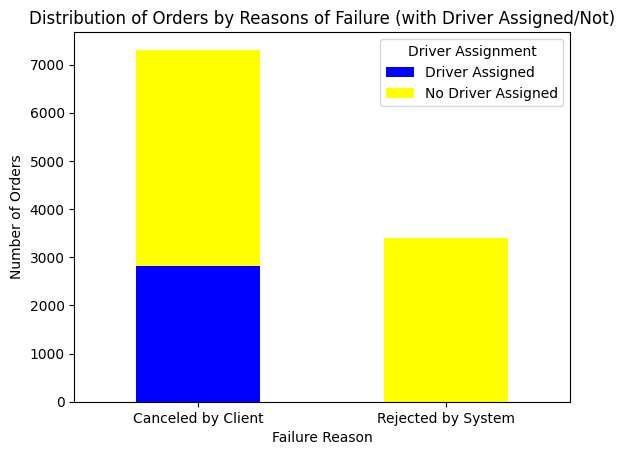

In [13]:
# 1. Orders by reasons of failure

# Mapping
status_mapping = {4: 'Canceled by Client', 9: 'Rejected by System'}
df_orders['order_status'] = df_orders['order_status_key'].map(status_mapping)

driver_assigned_mapping = {1: 'Driver Assigned', 0: 'No Driver Assigned'}
df_orders['driver_assigned'] = df_orders['is_driver_assigned_key'].map(driver_assigned_mapping)

# Create a pivot table to show the distribution of failure reason
failure_distribution = pd.pivot_table(df_orders,
                                      values='order_gk',
                                      index='order_status',
                                      columns='driver_assigned',
                                      aggfunc='count',
                                      fill_value=0)

# Plot
failure_distribution.plot(kind='bar', stacked=True, color=['blue', 'yellow'])
plt.title('Distribution of Orders by Reasons of Failure (with Driver Assigned/Not)')
plt.xlabel('Failure Reason')
plt.ylabel('Number of Orders')
plt.xticks(rotation=0)
plt.legend(title='Driver Assignment')
plt.show()

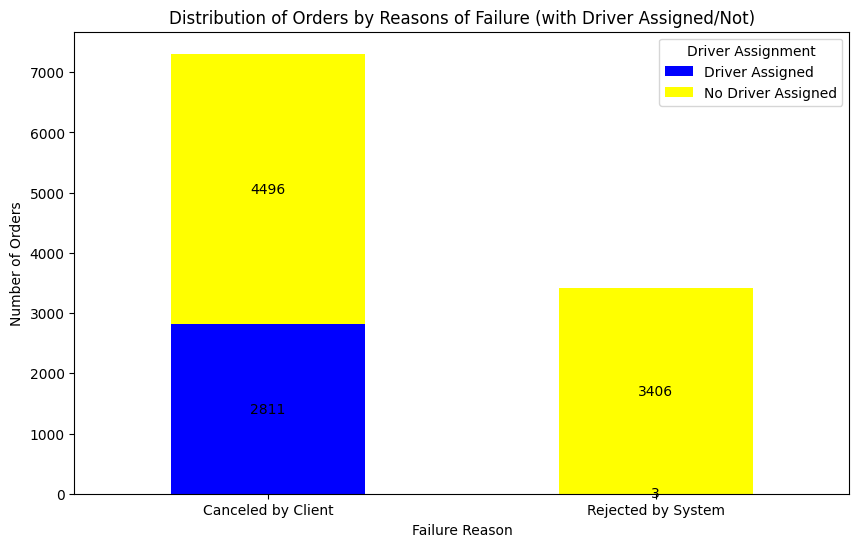

In [73]:
# Plot the stacked bar chart
ax = failure_distribution.plot(kind='bar', stacked=True, color=['blue', 'yellow'], figsize=(10, 6))

# Add a title and labels
plt.title('Distribution of Orders by Reasons of Failure (with Driver Assigned/Not)')
plt.xlabel('Failure Reason')
plt.ylabel('Number of Orders')
plt.xticks(rotation=0)
plt.legend(title='Driver Assignment')

# Add numbers
for container in ax.containers:
    # Add data labels
    ax.bar_label(container, label_type='center', fmt='%.0f')

plt.show()

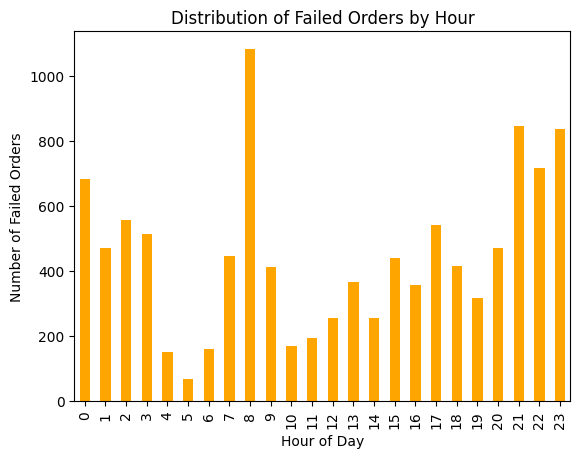

In [75]:
# 2. Fails by hours
# Convert order_datetime to datetime format and extract the hour
df_orders['order_datetime'] = pd.to_datetime(df_orders['order_datetime'])
df_orders['order_hour'] = df_orders['order_datetime'].dt.hour

# Plot
hourly_distribution = df_orders['order_hour'].value_counts().sort_index()
hourly_distribution.plot(kind='bar', color='orange')
plt.title('Distribution of Failed Orders by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Failed Orders')
plt.show()

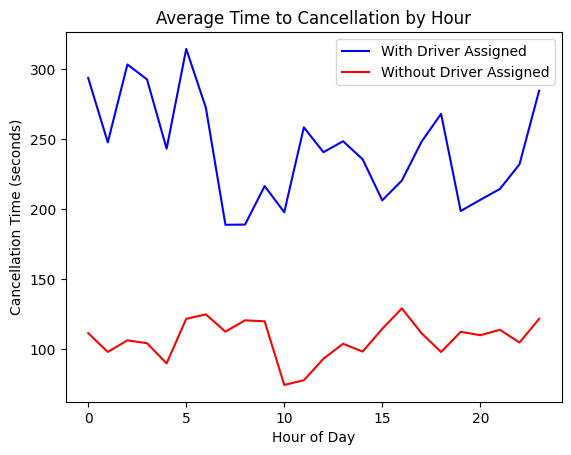

In [23]:
# 3. AVG time to Cancellation by Hours

# Group by whether a driver was assigned and the hour of the order
driver_assigned = df_orders[df_orders['is_driver_assigned_key'] == 1]
driver_not_assigned = df_orders[df_orders['is_driver_assigned_key'] == 0]

# Calculate mean cancellation time by hour
avg_cancel_with_driver = driver_assigned.groupby('order_hour')['cancellations_time_in_seconds'].mean()
avg_cancel_without_driver = driver_not_assigned.groupby('order_hour')['cancellations_time_in_seconds'].mean()

# Plot both lines
plt.plot(avg_cancel_with_driver.index, avg_cancel_with_driver, label='With Driver Assigned', color='blue')
plt.plot(avg_cancel_without_driver.index, avg_cancel_without_driver, label='Without Driver Assigned', color='red')
plt.title('Average Time to Cancellation by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Cancellation Time (seconds)')
plt.legend()
plt.show()

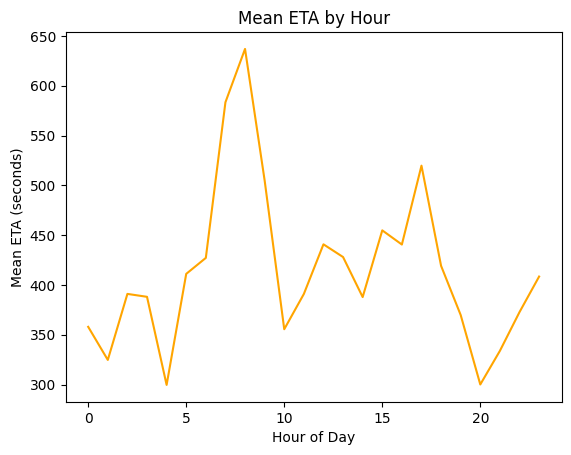

In [76]:
# 4. Mean ETA Over the Hours
mean_eta_by_hour = df_orders.groupby('order_hour')['m_order_eta'].mean()

# Plot the mean ETA over hours
mean_eta_by_hour.plot(kind='line', color='orange')
plt.title('Mean ETA by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Mean ETA (seconds)')
plt.show()

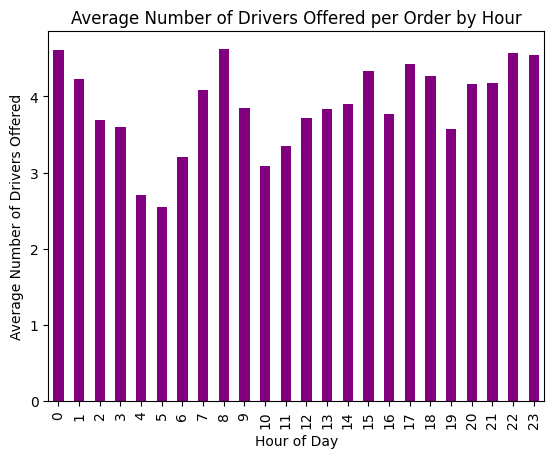

In [25]:
# 5. Hourly Breakdown of the Average Number of Drivers Offered an Order
# Merge with data_orders to get the order time
merged_data = pd.merge(df_orders[['order_gk', 'order_hour']], df_offers, on='order_gk', how='inner')

# Group by order hour and calculate the average number of drivers offered
drivers_offered_by_hour = merged_data.groupby('order_hour')['order_gk'].count() / merged_data.groupby('order_hour')['order_gk'].nunique()

# Plot the average number of drivers offered per order by hour
drivers_offered_by_hour.plot(kind='bar', color='purple')
plt.title('Average Number of Drivers Offered per Order by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Drivers Offered')
plt.show()

In [48]:
# Initialize map centered around a location
m = leafmap.Map(center=[51.455544, -0.969520], zoom=12)

# Add points to the map
m.add_points_from_xy(df_orders, x="origin_longitude", y="origin_latitude", popup="order_datetime")

# Save the map to an HTML file
m.to_html("map.html")

In [72]:
import folium
from folium.plugins import HeatMap

# Create a map centered around a location
m = folium.Map(location=[51.455544, -0.969520], zoom_start=12)

# Prepare data for the heatmap (latitude, longitude, and weight for intensity)
heat_data = [[row['origin_latitude'], row['origin_longitude']] for index, row in df_orders.iterrows()]

# Add a heatmap layer
HeatMap(heat_data).add_to(m)

# Save the map to an HTML file
m.save("cancellation_heatmap.html")


# heat map groups by hour
df_orders['order_hour'] = pd.to_datetime(df_orders['order_datetime']).dt.hour

# Define your custom hour groups
time_groups = {
    "0-3": (0, 4),
    "4-6": (4, 7),
    "6-9": (6, 10),
    "10-14": (10, 15),
    "15-20": (15, 21),
    "21-23": (21, 24)
}

# Loop through each time group and create a heatmap
for group, (start_hour, end_hour) in time_groups.items():
    # Filter data for the current time group
    df_group = df_orders[(df_orders['order_hour'] >= start_hour) & (df_orders['order_hour'] < end_hour)]

    # Prepare data for the heatmap (latitude, longitude for canceled orders)
    heat_data = [[row['origin_latitude'], row['origin_longitude']] for index, row in df_group.iterrows()]

    # Create a map centered around the same location
    m = folium.Map(location=[51.455544, -0.969520], zoom_start=12)

    # Add heatmap layer
    #HeatMap(heat_data).add_to(m)
    HeatMap(heat_data, radius=10, blur=10, min_opacity=0.3, max_opacity=0.7).add_to(m)

    # Save each time group's heatmap as an HTML file
    m.save(f"cancellation_heatmap_{group}.html")

    print(f"Saved heatmap for time group {group} as cancellation_heatmap_{group}.html")

Saved heatmap for time group 0-3 as cancellation_heatmap_0-3.html
Saved heatmap for time group 4-6 as cancellation_heatmap_4-6.html
Saved heatmap for time group 6-9 as cancellation_heatmap_6-9.html
Saved heatmap for time group 10-14 as cancellation_heatmap_10-14.html
Saved heatmap for time group 15-20 as cancellation_heatmap_15-20.html
Saved heatmap for time group 21-23 as cancellation_heatmap_21-23.html


order_gk
1           9
1-5        17
5-10       18
10-20      28
20-30      22
30-40      12
40-50      15
50-60      12
60-70      15
70-80       7
80-100     13
100-120     9
120-140     3
140-160     2
140+        7
Name: count, dtype: int64


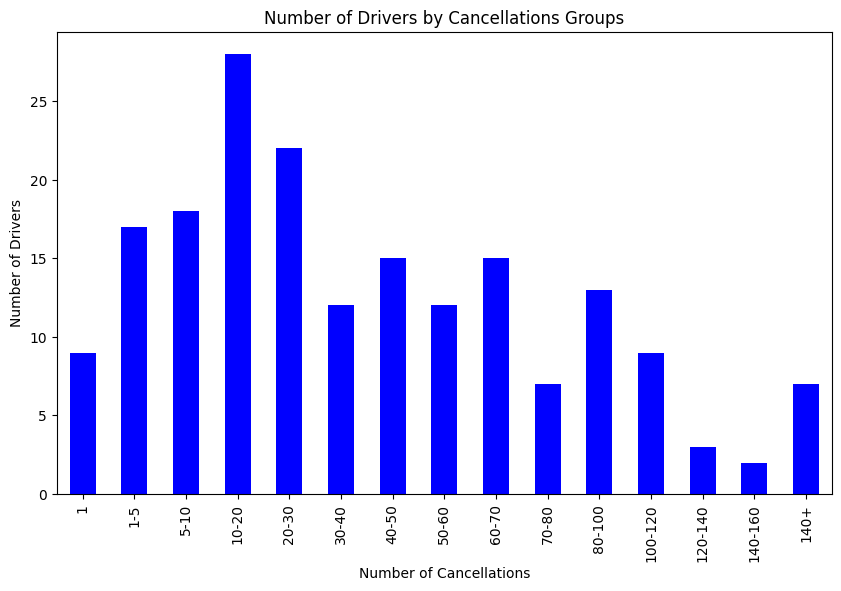

In [63]:
# 7. Number of Drivers by Cancellations Groups

# Merge data_orders and data_offers on order_gk to associate drivers with orders
df_orders_filtered = df_orders[df_orders['is_driver_assigned_key'] == 1]
merged_data = pd.merge(df_orders_filtered, df_offers[['order_gk', 'offered_driver_id']], on='order_gk', how='inner')

# Calculate total failed (canceled) orders for each driver
failed_offers_per_driver = merged_data.groupby('offered_driver_id')['order_gk'].nunique()

# Define bins for grouping drivers by the number of cancellations (you can adjust these thresholds as needed)
bins = [0, 1, 5, 10, 20, 30,40,50,60,70,80,100,120,140,160, float('inf')]  # Adjust as needed
labels = ['1', '1-5', '5-10', '10-20', '20-30', '30-40', '40-50','50-60','60-70','70-80','80-100', '100-120', '120-140', '140-160', '140+']

# Group drivers by the number of cancellations using the defined bins
cancellation_groups = pd.cut(failed_offers_per_driver, bins=bins, labels=labels, include_lowest=True)

# Count the number of drivers in each group
grouped_drivers = cancellation_groups.value_counts().sort_index()

print(grouped_drivers)

grouped_drivers.plot(kind='bar', color='blue', figsize=(10, 6))
plt.title('Number of Drivers by Cancellations Groups')
plt.xlabel('Number of Cancellations')
plt.ylabel('Number of Drivers')
plt.show()